# The optimal $K$-sparse estimator

Write-up [here](https://www.overleaf.com/5144282174mzzmgkyqcyxd)

In [1]:
from arsenal import Integerizer
from arsenal.maths import random_dist, softmax, d_softmax
from arsenal.maths.combinatorics import choose
from collections import Counter
from scipy.optimize import minimize
from scipy.special import binom 

In [2]:
class ExplicitDistributionOverSets:
    def __init__(self, P, n, k):
        self.n, self.k = n, k
        self.P = dict(P)
        self.U = range(n)
        self.p1 = np.zeros(n)
        for Y, p in self.P.items():
            assert len(Y) == k   # sanity check
            for i in Y: self.p1[i] += p
        Z = sum(self.P.values())
        assert np.allclose(Z, 1.0), Z   # sanity check

    def objective(self, p):
        return sum((p[i]**2 / self.p1[i]) - p[i]**2 for i in self.U)

    def gradient(self, p):
        g = Counter()
        for Y in self.P:
            for i in Y:
                g[Y] += -p[i]**2 / self.p1[i]**2
        return g    
    
    def objective_slow(self, p):
        "Slower implementation of objective, used to test the math."
        return sum(self.P[Y] * sum(((p[i] / self.p1[i]) * (i in Y) - p[i])**2 for i in self.U) for Y in self.P)

    def objective_l1(self, p):
        return sum(self.P[Y] * sum(abs((p[i] / self.p1[i]) * (i in Y) - p[i]) for i in self.U) for Y in self.P)
        
    def sample(self):
        domain = list(self.P.keys())
        i = sample(list(self.P.values()))
        return domain[i]

    def show(self):
        for prob, s in sorted(zip(self.P.values(), self.P.keys()), reverse=True):
            if prob > 1e-5:
                print(f'{prob:.3}: {sorted(s)}')
                

To get avoid needing to worry about the constraints that ensure that Q is a distribution, we use a softmax parameterization.

In [3]:
class Thing(ExplicitDistributionOverSets):
    def __init__(self, w, n, k):
        assert len(w) == binom(n, k)
        self.w = w
        self.p = softmax(w)
        U = list(range(n))
        self.ix = ix = Integerizer()
        P = {frozenset(Y): self.p[ix(frozenset(Y))] for Y in choose(U, k)}
        super().__init__(P, n, k)

    def gradient(self, p):
        dP_ = super().gradient(p)
        # remap via the integerization mapping
        ix = self.ix
        dP = np.zeros_like(self.p)
        for Y, d in dP_.items(): dP[ix(Y)] = d
        return d_softmax(self.p, None, dP)
        
    @classmethod
    def fit(cls, p, n, k):
        sol = minimize(
            lambda w: cls(w, n=n, k=k).objective(p),
            np.zeros(int(binom(n,k))),
            jac = lambda w: cls(w, n=n, k=k).gradient(p),
        )
        return cls(sol.x, n=n, k=k)        

In [4]:
n = 10; k = 3
p = random_dist(n)


Comparison: n=120
  norms: [0.0291266, 0.0291266]
  zero F1: 1
  pearson: 1
  spearman: 1
  ℓ∞: 1.62053e-11
  ℓ₂: 6.20268e-11
  same-sign: 100.0% (120/120)
  regression: [1.000 -0.000]



100.0% (120/120) [====================================================] 00:00:00


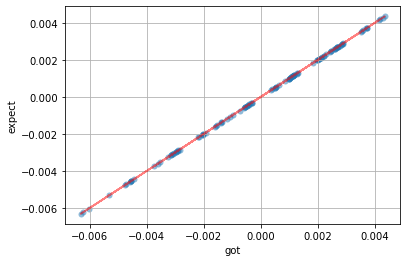

In [5]:
from arsenal.maths import fdcheck
theta = random_dist(int(binom(n,k)))
fdcheck(lambda: Thing(theta, n, k).objective(p), theta, Thing(theta, n, k).gradient(p), throw=False).show();

In [6]:
Dopt = Thing.fit(p, n, k)

In [7]:
#Dopt.show()

The optimality conditions say that the inclusion probabilities $\pi_j \propto p_j$.


Comparison: n=10
  norms: [1.19753, 1.19753]
  zero F1: 1
  pearson: 1
  spearman: 1
  ℓ∞: 2.55623e-05
  ℓ₂: 5.0664e-05
  same-sign: 100.0% (10/10)
  regression: [1.000 -0.000]



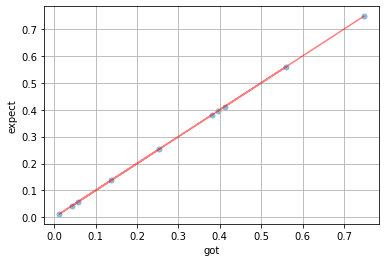

In [8]:
compare(Dopt.p1, p*k).show();

In [9]:
from swor.cps import ConditionalPoissonSampling as CPS

def opt_cps(p, k):
    # I think we can also optimize the KL divergence because it will give rise to an 
    # objective with this as its first-order optimality condition.
    sol = minimize(
        lambda w: np.sum((CPS(np.exp(w), k).inclusion() - k*p)**2),
        np.zeros(n)
    )
    return CPS(np.exp(sol.x), k)


Comparison: n=10
  norms: [1.19753, 1.19753]
  zero F1: 1
  pearson: 1
  spearman: 1
  ℓ∞: 4.7995e-06
  ℓ₂: 9.43137e-06
  same-sign: 100.0% (10/10)
  regression: [1.000 0.000]



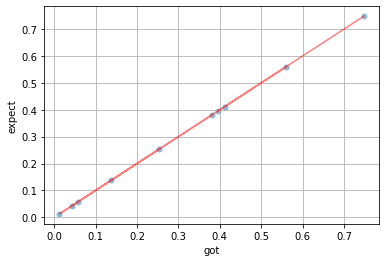

In [10]:
m = opt_cps(p, k)
compare(m.inclusion(), p*k).show();

In [11]:
from arsenal import iterview
models = [opt_cps(p, t) for t in iterview(range(1, k+1))]

100.0% (3/3) [========================================================] 00:00:00


In [12]:
#pl.matshow([m.inclusion() for m in models])

In [13]:
#pl.matshow([np.log(m.v) for m in models])

The [these slides](http://www.mathstat.helsinki.fi/msm/banocoss/2011/Presentations/Bondesson_web.pdf) describe the relationship between CPS parameters and inclusion probabilities.  The code below is slightly different because I didn't parameterize the distirbution by the odds.

In [14]:
#mm = opt_cps(p, k)
w = p
#pi = p * k
pi = CPS(w, k).inclusion()

# Compute w that gives rise to the inclusion probabilities that we want.
compare(w, pi/(1-pi) * np.exp((0.5 - pi) / (pi @ (1-pi))))#.show();

#pi = p
#compare(p, CPS(pi/(1-pi) * np.exp((0.5 - pi) / (pi @ (1-pi))), k).inclusion()).show()


Comparison: n=10
  norms: [0.399177, 2.26707]
  zero F1: 1
  pearson: 0.999999
  spearman: 1
  ℓ∞: 1.16573
  ℓ₂: 1.86789
  same-sign: 100.0% (10/10)
  regression: [0.176 -0.000]
  got is larger: 100.0% (10/10)



## K-best sampling

In [19]:
def complementary_sampling(p, s):
    "Complementary sampling"
    n = len(p)

    est = np.zeros((n, n))

    for k in range(1, n+1):
        S = s[:k-1]   # elements that are in the deterministic set.

        w = p.copy()
        w[S] = 0
        W = w.sum()

        j = sample(w)

        est[k-1, S] = p[S]
        est[k-1, j] = W

    return est

In [20]:
def dist_complementary_sampling(p, s, k):
    s = set(s[:k-1])
    assert len(s) == k-1
    
    # remaining probabilities
    w = p.copy()
    w[list(s)] = 0
    W = w.sum()
    
    # There are very few sets that have nonzero probability under this scheme (n-k)
    Q = Counter()
    for i in range(len(p)):
        if i not in s:
            Q[frozenset(s | {i})] = w[i]/W
    # sanity checks
    for y in Q: assert len(y) == k
    assert len(Q) == len(p)-k+1
    return ExplicitDistributionOverSets(Q, n, k)


kb = dist_complementary_sampling(p, np.argsort(-p), k)
kb.show()

0.243: [0, 2, 3]
0.234: [0, 1, 2]
0.226: [0, 2, 9]
0.15: [0, 2, 6]
0.081: [0, 2, 8]
0.0335: [0, 2, 5]
0.0247: [0, 2, 7]
0.00745: [0, 2, 4]


In [21]:
kb.objective(p), kb.objective_slow(p)

(0.2556353354707893, 0.2556353354707893)

In [22]:
def dist_cps(m, n, k): return ExplicitDistributionOverSets({Y: m.P(Y) for Y in m.domain()}, n, k)

#dist_cps(mm, n, k).objective(p)

In [23]:
Dopt.objective(p), Dopt.objective_slow(p)

(0.17399066795565837, 0.17399066795565837)

In [24]:
kb.objective_l1(p), Dopt.objective_l1(p)

(0.9067646748103814, 1.043943132574003)

# Adversarial problem

In [25]:
def incl(Q, n):
    p1 = np.zeros(n)
    for Y, py in Q.items():
        for i in Y: p1[i] += py
    return p1

def incl2(Q, n):
    p2 = np.zeros((n,n))
    for Y, py in Q.items():
        for i in Y:
            for j in Y:
                p2[i,j] += py
    return p2

def game(p, Q, f):
    p1 = incl(Q, n)
    m = p @ f
    return sum(Q[Y] * (sum((p[i] / p1[i]) * f[i] for i in Y) - m)**2 for Y in Q)

U = list(range(n))
ix = Integerizer()
def encode(w, n, k):
    assert len(w) == binom(n, k)
    q = softmax(w)
    return {frozenset(Y): q[ix(frozenset(Y))] for Y in choose(U, k)}

def softmax_game(w, n, k, p, f):
    return game(p, encode(w, n, k), f)

In [26]:
from arsenal.maths import spherical
f = spherical(n)

w = spherical(int(binom(n, k)))
#w = np.zeros(int(binom(n, k)))

# How close to uncorrelated can we get our inclusion probabilities to be?
def uncorr(w, n, k):
    P = encode(w, n, k)
    p1 = incl(P, n)
    p2 = incl2(P, n)
    return np.sum(np.square(p2 - np.outer(p1, p1)))

print('initial game:', softmax_game(w, n, k, p, f))

print('optimizing...')
sol = minimize(lambda w: uncorr(w, n, k), w)
ww = sol.x
print('uncorr score:', sol.fun, sol.message)
print('game:', softmax_game(ww, n, k, p, f))

initial game: 0.023788441494685644
optimizing...
uncorr score: 2.2097192354180427e-06 Optimization terminated successfully.
game: 7.380648669072252e+17


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.99998545 0.99925974]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.99998545 0.         0.         0.         0.
  0.         0.         0.99998545 0.9992452 ]
 [0.         0.99925974 0.         0.

0.0007545203436983952

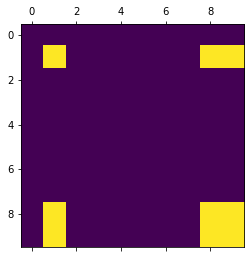

In [27]:
P = encode(ww, n, k)
p1 = incl(P, n)
p2 = incl2(P, n)

p2[p2 < .001] = 0
pl.matshow(p2)

print(p2)

abs(p2 - np.outer(p1, p1)).max()

In [28]:
C = opt_cps(p,k)
p1 = C.inclusion()
print(abs(p1 - k*p).max())

4.7994953915816985e-06


In [29]:
p2 = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        p2[i,j] = C.inclusion2(i,j)

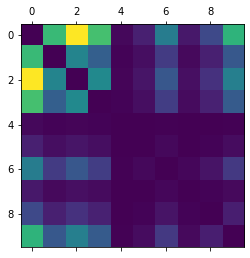

In [30]:
pl.matshow(p2)


Comparison: n=900
  norms: [3.17482, 4.30224]
  zero F1: 0
  pearson: 0.799377
  spearman: 0.755021
  ℓ∞: 0.559164
  ℓ₂: 2.20545
  same-sign: 100.0% (900/900)
  regression: [0.624 0.004]
  got is larger: 100.0% (900/900)



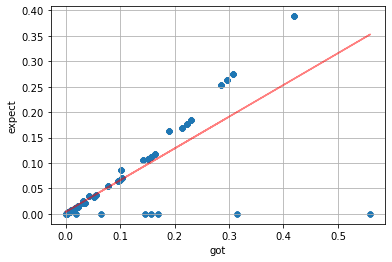

In [31]:
nd = [(i,j) for i in range(n) for j in range(i)]
compare(p2[nd], np.outer(p1, p1)[nd]).show()

In [32]:
for i,j in nd:
    want = p1[i]*p1[j]
    got = p2[i,j]
    print(i,j,want,got, abs(want-got)>1e-3)

1 0 0.2964780711464844 0.26344693177573547 True
2 0 0.41927757137786265 0.3885425460819087 True
2 1 0.22230779413494633 0.17597443128171095 True
3 0 0.3077268791381271 0.27453231298478403 True
3 1 0.16316180107706146 0.11723715659851672 True
3 2 0.23074247425007055 0.183965433057445 True
4 0 0.009418425848202124 0.007672519820459114 True
4 1 0.00499380271560103 0.003068611904783446 True
4 2 0.007062206882420225 0.0048809819638285555 True
4 3 0.0051832748329779165 0.0032132560003053966 True
5 0 0.042407936898085426 0.03484557653639242 True
5 1 0.022485378539676252 0.014003368712514832 True
5 2 0.03179869212306551 0.02225135538208156 True
5 3 0.0233385064112727 0.014662452271213659 True
5 4 0.0007143087164111407 0.00037875782968451664 False
6 0 0.1895336993097992 0.16250398508691913 True
6 1 0.10049385296077473 0.06709380734911527 True
6 2 0.14211782491994024 0.10601055584229982 True
6 3 0.10430673548501915 0.0702253677067357 True
6 4 0.003192458378628411 0.0018256665112030288 True
6 5 0